# Foundations of Data Mining: Assignment 1

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [2]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
# InteractiveShell.ast_node_interactivity = "all"

## Handwritten digit recognition (5 points, 1+2+2)
The [MNIST dataset](https://www.openml.org/d/554) contains 70,000 images of handwritten digits (0-9) represented by 28 by 28 pixel values. We can easily download it from OpenML and visualize one of the examples:

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

In [142]:
# Load MNIST data
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); # Get the predictors X and the labels y

- Evaluate a k-Nearest Neighbor classifier with its default settings.
    - Use the first 60,000 examples as the training set and the last 10,000 as the test set
    - What is the predictive accuracy?
    - Find a few misclassifications, and plot them together with the true labels (as above). Are these images really hard to classify?
- Optimize the value for the number of neighbors $k$ (keep $k$ < 50) on a stratified subsample (e.g. 10%) of the data
    - Use 10-fold crossvalidation and plot $k$ against the misclassification rate. Which value of $k$ should you pick?
    - Do the same but with 100 bootstrapping repeats. Are the results different? Explain.
- Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
    - First use the default hyperparameter settings.
    - Next, optimize for the degree of regularization ($C$) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results. 
    - Report is the optimal performance. Can you get better results than kNN?
    
Report all results clearly and interpret the results.  
Note: while prototyping/bugfixing, you can speed up experiments by taking a smaller sample of the data, but report your results as indicated above.

In [3]:
# Import all libraries
from sklearn import neighbors, linear_model
import math

### Evaluating a k-Nearest Neighbor classifier with its default settings.
We first evaluate the k-Nearest Neighbor classifier with the default settings on the data. We calculate the predictive accuracy and plot several misclassifications of the classifier. 

Running on 70000 elements with 60000 train size
Predictive accuracy: 0.968800


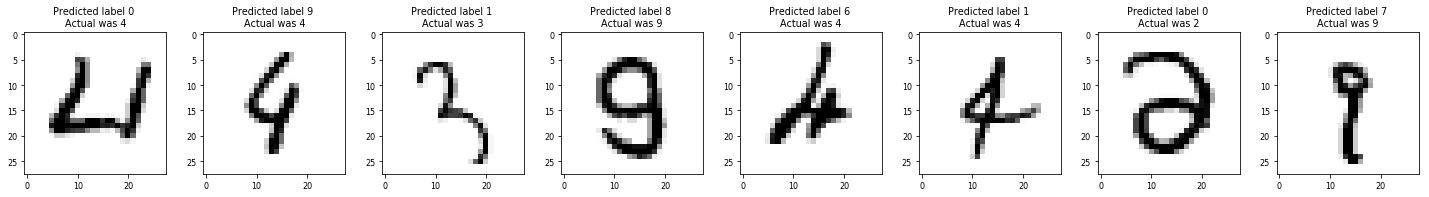

In [35]:
# -- Settings --
samples = 8                                 # The number of invalid samples to plot
dataSize = 70000                            # The size of our data
split = 60000/dataSize                      # Split percentage
percentage = 1                           # A multiplier which controls the percentage of data we use, set to 1 to run with all data
numElements = int(percentage*dataSize)      # The number of elements we actually use in the run
trainSize = int(percentage*dataSize*split)  # The size of the training dataset

# Print the amount of elements we run on
print("Running on %i elements with %i train size" % (numElements, trainSize))

# Split 60.000/10.000 for both the predictors and labels
X_train, X_test = np.split(X[:numElements],[trainSize])
y_train, y_test = np.split(y[:numElements],[trainSize])

# Initialize knn with default values
knn = neighbors.KNeighborsClassifier()

# Fit knn to training data
knn.fit(X_train, y_train)

# Use knn to predict test data
y_pred = knn.predict(X_test)

# Print predictive accuracy
print('Predictive accuracy: %f' % knn.score(X_test, y_test))

# Print {samples} amount of figures with wrong results
fig, axes = plt.subplots(1, samples, figsize=(20, 3))
plt.tight_layout() 
sample = 0
i = 0
while sample < samples or i > len(y_pred):
    if (y_pred[i] != y_test[i]):
        axes[sample].imshow(X_test[i].reshape(28, 28), cmap=plt.cm.gray_r)
        axes[sample].set_title("Predicted label {} \nActual was {}".format(y_pred[i], y_test[i]))
        sample += 1
    i+=1
    
plt.show()

When looking at the invalid classifications, some are unexpected. For example: the fourth sample (the 9) is clearly an 9 and does not seem significantly hard.

However, most samples are indeed very hard. For example, the 1st sample (the 4) does not look like a 4 at all. Similarly, the 7th sample (the 2) is extremely sloppy, as to the point where we feel it does not represent a number at all.

Therefore, we conclude the classifier can definitly be improved, however, we also note that some samples are very difficult, even for a human to predict the correct result.

### Optimizing the kNN classifier
We started to look for optimization methods for the kNN classifier, using 10-fold crossvalidation we attempted to find the optimal k for our model by plotting the train and test accuracy of different values of k. 

Additionally, we did the same but this time with 100 bootstrapping repeats. This is done as follows:

Testing k values


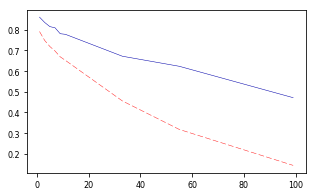

In [118]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

# -- Settings --
percentage = 0.005                           # A multiplier which controls the percentage of data we use, set to 1 to run with all data

# Build a list of the training and test scores for increasing amount of neighbors
test_accuracy = []
accuracy_bootstrap = []

# Create k-fold and bootstrap
kf = KFold(n_splits=10, shuffle=True, random_state=0)
bootstrap = ShuffleSplit(test_size=.66, train_size=.34, n_splits=100)

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Set range of k values to be tested
k = [1, 3, 5, 7, 9, 11, 33, 55, 99]
print("Testing k values");

# uses kf-old testing to find training and test accuracy for different amount of neighbors
for n_neighbors in k:
    m = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Do a kfold test with this k
    results = cross_val_score(m, x_data, y_data, cv=kf)
    test_accuracy.append(results.mean())
    
    # Do a bootstrap test with this k
    results = cross_val_score(m, x_data, y_data, cv=bootstrap)
    accuracy_bootstrap.append(results.mean())
    
# Plot the results
plt.plot(k, test_accuracy, label="test accuracy")
plt.plot(k, accuracy_bootstrap, label="bootstrap accuracy")

When we look at the results without the bootstrapping repeats, it is clear we should take k=1. The test accuracy is the highest for this model.

When using bootstrapping (red line), the results are clearly worse. This is likely due to :TODO: however, it is also clear we should use k=1.

### Comparing kNN to linear classification models
After receiving our results from kNN we compared these on both the logistic regression as well as linear SVM classification models as follows:

Model: LinearSVC has performance of: 0.817142857143
Model: LogisticRegression has performance of: 0.834285714286


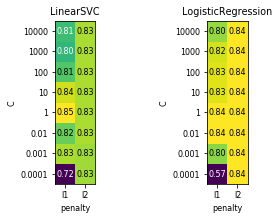

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
import pandas as pd

# -- Settings --
percentage = 0.01       # A multiplier which controls the percentage of data we use, set to 1 to run with all data

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Create data
X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=0)

# Run for default
for m in [LinearSVC, LogisticRegression]:
    model = m()
    model.fit(X_train, y_train)
    print("Model: %s has performance of: %s" % (m.__name__, model.score(X_test, y_test)))
    
# Run for several parameters
param_grid = { 'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000], 'penalty': ["l1", "l2"] }

fig, axes = plt.subplots(1, 2)
for (m, ax) in zip([LinearSVC, LogisticRegression], axes):
    grid_search = GridSearchCV(m(dual=False), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Visualize all results
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(8, 2)

    # plot the mean cross-validation scores
    ax.set_title(m.__name__)
    mglearn.tools.heatmap(scores, ax=ax, xlabel='penalty', xticklabels=param_grid['penalty'],
                          ylabel='C', yticklabels=param_grid['C'], cmap="viridis");
    
plt.show()
# Compare kNN against the linear classification models that we have covered in the course (logistic regression and linear SVMs).
# First use the default hyperparameter settings.
# Next, optimize for the degree of regularization ( CC ) and choice of penalty (L1/L2). Again, plot the accuracy while increasing the degree of regularization for different penalties. Interpret the results.
# Report is the optimal performance. Can you get better results than kNN?


What we can see is that the L1 penalty tends to be worse compared to the L2 penalty. Additionally, we can see that linear SVM is not much better nor worse compared to Logistic Regression.

Additionally, varying the degree of regularization does not change the test results as much.

No matter what sort of model we build, we found out that kNN clearly results in a better model compared to the linear classification methods.

## Model selection (4 points (2+2))
Study how RandomForest hyperparameters interact on the Ionosphere dataset (OpenML ID 59).

- Optimize a RandomForest, varying both $n\_estimators$ and $max\_features$ at the same time. Use a nested cross-validation and a grid search (or random search) over the possible values, and measure the AUC. Explore how fine-grained this grid/random search can be, given your computational resources. What is the optimal AUC performance you find?
- Again, vary both hyperparameters, but this time use a grid search and visualize the results as a plot (heatmap) $n\_estimators \times max\_features \rightarrow AUC$ with AUC visualized as the color of the data point. Try to make the grid as fine as possible. Interpret the results. Can you explain your observations? What did you learn about tuning RandomForests?

Hint: Running this experiment can take a while, so start early and use a feasible grid/random search. Start with a coarse grid or few random search iterations.
Hint: Use a log scale (1,2,4,8,16,...) for $n\_estimators$. Vary $max\_features$ linearly between 1 and the total number of features. Note that, if you give $max\_features$ a float value, it will use it as [the percentage of the total number of features](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


In [ ]:
from sklearn.ensemble import RandomForestClassifier

ionosphere = oml.datasets.get_dataset(59) # Download Ionosphere data
X, y = ionosphere.get_data(target=ionosphere.default_target_attribute); # Get the predictors X and the labels y

# -- Settings --
percentage = 0.1       # A multiplier which controls the percentage of data we use, set to 1 to run with all data

plt.figure(figsize=(30,10))

# reduce data set size by the given percentage
x_data = X[:int(len(X)*percentage)];
y_data = y[:int(len(y)*percentage)];

# Create data
X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, random_state=0)

# Run for several parameters
param_grid = { 'n_estimators': [1, 2, 4, 8, 16, 32, 64], 'max_features': list(range(1,35)) }

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Visualize all results
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 34)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, ylabel='n_estimators', yticklabels=param_grid['n_estimators'],
                      xlabel='max_features', xticklabels=param_grid['max_features'], cmap="viridis");


## Decision tree heuristics (1 point)
Consider the toy training set created below. It predicts whether your date agrees to go out with you depending on the weather.

Learn a decision tree:

- Implement functions to calculate entropy and information gain
- What is the class entropy for the entire dataset? What is the information gain when you split the data using the *Water* feature?
- Implement a basic decision tree:
    - Select a feature to split on according to its information gain. If multiple features are equally good, select the leftmost one.
    - Split the data and repeat until the tree is complete.
    - Print out the results (nodes and splits).
- Now train a scikit-learn decision tree on the same data. Do you get the same result? Explain.

In [12]:
df = pd.DataFrame({"Sky":['sunny','sunny','rainy','sunny','sunny'],
                   "AirTemp":['warm','warm','warm','cold','warm'],
                   "Humidity":['normal','high','high','high','normal'],
                   "Wind":['strong','strong','strong','strong','weak'],
                   "Water":['warm','warm','cool','warm','warm'],
                   "Forecast":['same','same','change','change','same'],
                   "Date?":['yes','yes','no','yes','no']
                   });
df = df[['Sky', 'AirTemp', 'Humidity', 'Wind', 'Water', 'Forecast', 'Date?']] # Fix column ordering
df # print

,Sky,AirTemp,Humidity,Wind,Water,Forecast,Date?
0,sunny,warm,normal,strong,warm,same,yes
1,sunny,warm,high,strong,warm,same,yes
2,rainy,warm,high,strong,cool,change,no
3,sunny,cold,high,strong,warm,change,yes
4,sunny,warm,normal,weak,warm,same,no


In [13]:
# Complete these functions first
def entropy(pos, neg):
    return 0

def info_gain(pos1,neg1,pos2,neg2):
    return 0

## Random Forests (4 points (1+1+2))
Study the effect of the number of trees in a RandomForest on the EEG-eye-state dataset (http://www.openml.org/d/1471). This dataset measures brain activity using 15 sensors, and you need to predict whether the person's eyes are open or closed. 

* Train a RandomForest classifier on this dataset with an increasing number of trees (on a log scale as above). Plot the Out-Of-Bag error against the number of trees.
    - The Out-Of-Bag error is the test error obtained when using bootstrapping, and using the non-drawn data points as the test set. This is what a RandomForest does internally, so you can retrieve it from the classifier. The code below hints on how to do this.
* Construct the same plot, but now use 10-fold Cross-validation and error rate instead of the OOB error. Compare the two. What do you learn from this?
* Compare the performance of the RandomForest ensemble with that of a single full decision tree. Compute the AUC as well as the bias and variance. Does the bias and variance increase/decrease for the ensemble? Does the number of trees affect the result?

Hint: Error rate = 1 - accuracy  
Hint: We discussed bias-variance decomposition in class. It is not included in scikit-learn, so you'll need to implement it yourself.

In [14]:
eeg = oml.datasets.get_dataset(1471) # Download Ionosphere data
X, y = eeg.get_data(target=eeg.default_target_attribute);

# Out of bag errors can be retrieved from the RandomForest classifier. You'll need to loop over the number of trees.
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from sklearn import ensemble
clf = ensemble.RandomForestClassifier()
clf.fit(X, y)
(1 - clf.oob_score)

1

## A regression benchmark (1 point)
Consider the liver-disorder dataset (http://www.openml.org/d/8). The goal is to predict how much alcohol someone consumed based on blood test values.

- Take a selection of the algorithms that we covered in class that can do regression.
- Based on what you learned in the previous exercises, make educated guesses about good hyperparameter values and set up a grid or random search.
- Evaluate all models with 10-fold cross-validation and root mean squared error (RMSE). Report all results. Which model yields the best results?

In [132]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

# Load data
liver = oml.datasets.get_dataset(8) # Download Liver-disorders data
X, y = liver.get_data(target=liver.default_target_attribute);

loo = LeaveOneOut()
kf = KFold(n_splits=10, shuffle=True, random_state=0)

for m in [KNeighborsRegressor, LinearSVC, LogisticRegression]:
    model = m()
    print(cross_val_score(model, X, y, cv=loo))
    print(cross_val_score(model, X, y, cv=kf))
    

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0